In [331]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import tensorflow as tf
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [332]:
# Load Data
df = pd.read_csv("source data/twitter_human_bots_dataset.csv")

In [333]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [334]:
# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Calculate Account Age
current_time = datetime.now()
df['account_age_days'] = (current_time - df['created_at']).dt.days

# Time-Based Features
df['creation_hour'] = df['created_at'].dt.hour
df['creation_day_of_week'] = df['created_at'].dt.dayofweek
df['creation_month'] = df['created_at'].dt.month
df['creation_year'] = df['created_at'].dt.year
df['creation_quarter'] = df['created_at'].dt.quarter
df['is_weekend'] = df['creation_day_of_week'] >= 5
df['creation_week_of_year'] = df['created_at'].dt.isocalendar().week
df['is_beginning_of_month'] = df['created_at'].dt.day <= 5
df['is_end_of_month'] = df['created_at'].dt.day >= 26

# Define part of day based on hour
def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['creation_hour'].apply(part_of_day)

# Additional Features
humans_mean = df[df['account_type'] == 'human']['average_tweets_per_day'].mean()
humans_std = df[df['account_type'] == 'human']['average_tweets_per_day'].std()
df['deviation_from_humans'] = (df['average_tweets_per_day'] - humans_mean) / humans_std

# Description Length Feature
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Followers/Friends Ratios
df['followers_to_friends_ratio'] = df['followers_count'] / df['friends_count']
df['followers_to_friends_ratio'].fillna(0, inplace=True)

# Followers to Tweets Per Day Ratio
df['followers_to_tweets_per_day_ratio'] = df['followers_count'] / df['average_tweets_per_day']
df['followers_to_tweets_per_day_ratio'].fillna(0, inplace=True)

# Mentions Count in Description
import re

def extract_mentions(description):
    return re.findall(r'@\w+', str(description))

df['mentions'] = df['description'].apply(extract_mentions)
df['mention_count'] = df['mentions'].apply(len)

# Ensure any remaining NaN values are filled if necessary
########################################################################
# TO DISCUSS METHOD OF IMPUTATION
########################################################################
df.fillna(0, inplace=True)
df.replace(np.inf,0, inplace = True)

In [335]:
# Encoding Categorical Features
df['account_type'] = df['account_type'].map({'human': 0, 'bot': 1})

encode_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'lang', 'location', 'verified',
               'creation_year', 'is_weekend', 'is_beginning_of_month', 'is_end_of_month', 'part_of_day']

label_encoder = LabelEncoder()
for col in encode_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string to handle NaNs if any


# Define Feature Columns and Target
id_col = ['id']
labels = ['account_type']
predictive_cols = ['default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count',
                   'geo_enabled', 'lang', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 
                   'account_age_days', 'creation_hour', 'creation_day_of_week', 'creation_month', 'creation_year',
                   'creation_quarter', 'is_weekend', 'creation_week_of_year', 'is_beginning_of_month', 
                   'is_end_of_month', 'part_of_day', 'deviation_from_humans', 'description_length', 
                   'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'mention_count','account_type']

print(df.describe())

         Unnamed: 0                     created_at  default_profile  \
count  37438.000000                          37438     37438.000000   
mean   18718.500000  2012-05-10 19:06:11.558710528         0.419894   
min        0.000000            2006-07-05 19:52:46         0.000000   
25%     9359.250000  2009-12-26 20:54:38.750000128         0.000000   
50%    18718.500000            2011-10-27 02:04:41         0.000000   
75%    28077.750000            2014-04-16 15:39:40         1.000000   
max    37437.000000            2019-04-24 08:53:21         1.000000   
std    10807.564026                            NaN         0.493548   

       default_profile_image  favourites_count  followers_count  \
count           37438.000000      37438.000000     3.743800e+04   
mean                0.014905      12302.062183     3.703098e+05   
min                 0.000000          0.000000     0.000000e+00   
25%                 0.000000        362.000000     3.500000e+01   
50%                 0.000

In [336]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

predictive_cols = ['default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count',
                   'geo_enabled', 'lang', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 
                   'account_age_days', 'creation_hour', 'creation_day_of_week', 'creation_month', 'creation_year',
                   'creation_quarter', 'is_weekend', 'creation_week_of_year', 'is_beginning_of_month', 
                   'is_end_of_month', 'part_of_day', 'deviation_from_humans', 'description_length', 
                   'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'mention_count', 'description', 'account_type']

# Set cutoff date for training/validation split
cutoff_date = pd.to_datetime('2017-01-01')
df['date'] = pd.to_datetime(df['created_at'])

# Define columns to keep
id_cols = ['id']
# Assuming predictive_cols is already defined
columns_to_keep = id_cols + predictive_cols
df_filtered = df[columns_to_keep + ['date']]

# Split data based on cutoff date
oot = df_filtered[df_filtered['date'] >= cutoff_date].set_index('id')
df_model = df_filtered[df_filtered['date'] < cutoff_date].set_index('id')

# Drop date column as it's no longer needed
oot = oot.drop('date', axis=1)
df_model = df_model.drop('date', axis=1)
# print(df_model.columns)

### Tokenization

In [337]:
def process_text(text):
    # Check if the input is not a string, return an empty string if so
    if not isinstance(text, str):
        return ""
    
    # Replace links with {link} and videos with [video]
    text = re.sub(r'{link}', '', text)
    text = re.sub(r"\[video\]", '', text)
    
    # Convert to lowercase
    text = text.lower()

    return text

# Process text
texts = df_model['description'].apply(lambda x: process_text(x))

vocab_size = 14225
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Tokenize text
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure they all have the same length
# Using 75th percentile of description lengths as max_length
description_lengths = df_model['description'].apply(lambda x: len(str(x).split()))
max_length = description_lengths.quantile(0.75).astype(int)

### Split into train, test and validation sets

In [338]:
from sklearn.model_selection import train_test_split

# Split into train and test set
y = df_model['account_type']
x_text = pad_sequences(sequences, maxlen=max_length, padding='post')
x_num = df_model.drop(columns=['description', 'account_type'])

x_text_train, x_text_test, x_num_train, x_num_test, y_train, y_test = train_test_split(
    x_text, x_num, y, test_size=0.2, random_state=42)

# Further split the train set to create a validation set
x_text_train, x_text_val, x_num_train, x_num_val, y_train, y_val = train_test_split(
    x_text_train, x_num_train, y_train, test_size=0.2, random_state=42)


### Create DataLoader

In [339]:
import torch
from torch.utils.data import Dataset, DataLoader

class TwitterDataset(Dataset):
    def __init__(self, text_data, num_data, labels):
        self.text_data = torch.tensor(text_data, dtype=torch.long)
        self.num_data = torch.tensor(num_data.astype('float32').values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': self.text_data[idx],
            'numerical': self.num_data[idx],
            'label': self.labels[idx]
        }

train_dataset = TwitterDataset(x_text_train, x_num_train, y_train)
validation_dataset = TwitterDataset(x_text_val, x_num_val, y_val)
test_dataset = TwitterDataset(x_text_test, x_num_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Neural Network Model

In [340]:
import torch.nn as nn

class TwitterBotDetector(nn.Module):
    def __init__(self, num_numerical_features, embedding_dim, hidden_dim):
        super(TwitterBotDetector, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.fc1 = nn.Linear(embedding_dim + num_numerical_features, hidden_dim)
        # Add dropout
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_text, x_num):
        x_embed = self.embedding(x_text)
        x_embed = x_embed.mean(dim=1)  # Average embeddings over the sequence
        x = torch.cat((x_embed, x_num), dim=1)  # Concatenate text and numerical features
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

### Loss Function and Optimizer

In [341]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
model = TwitterBotDetector(num_numerical_features=x_num.shape[1], 
                           embedding_dim=EMBEDDING_DIM, 
                           hidden_dim=HIDDEN_DIM)

# Binary Cross Entropy Loss for binary classification
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [342]:
num_epochs = 5

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        text_batch = batch['text']
        num_batch = batch['numerical']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(text_batch, num_batch)
        loss = criterion(outputs, labels.float().view(-1, 1))
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # Calculate training accuracy
        predicted = (outputs > 0.5).float()
        correct_train += (predicted.view(-1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_accuracy = correct_train / total_train
    average_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in validation_loader:
            text_batch = batch['text']
            num_batch = batch['numerical']
            labels = batch['label']

            outputs = model(text_batch, num_batch)
            loss = criterion(outputs, labels.float().view(-1, 1))
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()
            correct_val += (predicted.view(-1) == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    average_val_loss = val_loss / len(validation_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/5], Train Loss: 26.1203, Train Accuracy: 0.7229, Val Loss: 24.7431, Val Accuracy: 0.7469
Epoch [2/5], Train Loss: 24.0716, Train Accuracy: 0.7508, Val Loss: 25.3973, Val Accuracy: 0.7422
Epoch [3/5], Train Loss: 24.9313, Train Accuracy: 0.7440, Val Loss: 29.3959, Val Accuracy: 0.7041
Epoch [4/5], Train Loss: 23.9294, Train Accuracy: 0.7546, Val Loss: 22.6282, Val Accuracy: 0.7660
Epoch [5/5], Train Loss: 23.8442, Train Accuracy: 0.7568, Val Loss: 23.9156, Val Accuracy: 0.7574


### Evaluation

In [343]:
model.eval()
total = 0
correct = 0
total_loss = 0

with torch.no_grad():
    for batch in test_loader:
        text_batch = batch['text']
        num_batch = batch['numerical']
        labels = batch['label']

        outputs = model(text_batch, num_batch)
        
        # Calculate loss with raw outputs and actual labels
        loss = criterion(outputs, labels.float().view(-1, 1))
        total_loss += loss.item()
        
        # Calculate accuracy with thresholded predictions
        predicted = (outputs > 0.5).float()
        correct += (predicted.view(-1) == labels).sum().item()
        total += labels.size(0)

    average_test_loss = total_loss / len(test_loader)
    test_accuracy = correct / total

    print(f'Test Loss: {average_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 23.8426
Test Accuracy: 0.7562


### GridSearch

In [344]:
import itertools
import torch
from torch.utils.data import DataLoader

param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'embedding_dim': [50, 100],
    'hidden_dim': [64, 128]
}

def train_and_evaluate(learning_rate, batch_size, embedding_dim, hidden_dim):
    model = TwitterBotDetector(num_numerical_features=x_num_train.shape[1],
                               embedding_dim=embedding_dim,
                               hidden_dim=hidden_dim)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(5):
        model.train()
        for batch in train_loader:
            text_batch = batch['text']
            num_batch = batch['numerical']
            labels = batch['label']
            optimizer.zero_grad()
            outputs = model(text_batch, num_batch)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
    
    # Validation evaluation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            text_batch = batch['text']
            num_batch = batch['numerical']
            labels = batch['label']
            outputs = model(text_batch, num_batch)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.view(-1) == labels).sum().item()

    val_accuracy = correct / total
    return val_accuracy

# Grid Search
best_accuracy = 0
best_params = {}

for params in itertools.product(*param_grid.values()):
    learning_rate, batch_size, embedding_dim, hidden_dim = params
    val_accuracy = train_and_evaluate(learning_rate, batch_size, embedding_dim, hidden_dim)
    
    print(f"Params: lr={learning_rate}, batch_size={batch_size}, embedding_dim={embedding_dim}, hidden_dim={hidden_dim} -> Val Accuracy: {val_accuracy:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim
        }

print(f"Best Validation Accuracy: {best_accuracy:.4f} with parameters: {best_params}")

Params: lr=0.001, batch_size=16, embedding_dim=50, hidden_dim=64 -> Val Accuracy: 0.7526
Params: lr=0.001, batch_size=16, embedding_dim=50, hidden_dim=128 -> Val Accuracy: 0.5525
Params: lr=0.001, batch_size=16, embedding_dim=100, hidden_dim=64 -> Val Accuracy: 0.7632
Params: lr=0.001, batch_size=16, embedding_dim=100, hidden_dim=128 -> Val Accuracy: 0.7491
Params: lr=0.001, batch_size=32, embedding_dim=50, hidden_dim=64 -> Val Accuracy: 0.7592
Params: lr=0.001, batch_size=32, embedding_dim=50, hidden_dim=128 -> Val Accuracy: 0.7001
Params: lr=0.001, batch_size=32, embedding_dim=100, hidden_dim=64 -> Val Accuracy: 0.7632
Params: lr=0.001, batch_size=32, embedding_dim=100, hidden_dim=128 -> Val Accuracy: 0.7645
Params: lr=0.01, batch_size=16, embedding_dim=50, hidden_dim=64 -> Val Accuracy: 0.3131
Params: lr=0.01, batch_size=16, embedding_dim=50, hidden_dim=128 -> Val Accuracy: 0.6869
Params: lr=0.01, batch_size=16, embedding_dim=100, hidden_dim=64 -> Val Accuracy: 0.3131
Params: lr=0.0

### Test with best parameters and generate confusion matrix

Test Loss: 21.5103
Final Test Accuracy: 0.7823


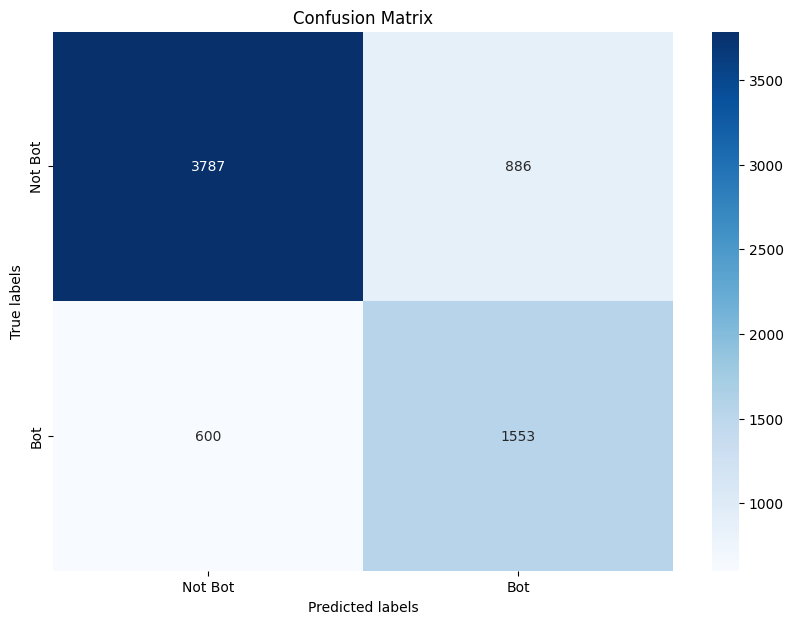

In [345]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train final model with the best hyperparameters on both train and validation sets
final_train_val_dataset = torch.utils.data.ConcatDataset([train_dataset, validation_dataset])
final_train_loader = DataLoader(final_train_val_dataset, batch_size=best_params['batch_size'], shuffle=True)

final_model = TwitterBotDetector(num_numerical_features=x_num_train.shape[1],
                                 embedding_dim=best_params['embedding_dim'],
                                 hidden_dim=best_params['hidden_dim'])
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# Training with the combined train and validation set
for epoch in range(5):
    final_model.train()
    for batch in final_train_loader:
        text_batch = batch['text']
        num_batch = batch['numerical']
        labels = batch['label']
        final_optimizer.zero_grad()
        outputs = final_model(text_batch, num_batch)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        final_optimizer.step()

# Final evaluation on the test set
final_model.eval()
total_loss = 0
correct = 0
total = 0

# Lists to collect all true labels and predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        text_batch = batch['text']
        num_batch = batch['numerical']
        labels = batch['label']

        outputs = final_model(text_batch, num_batch)
        
        # Calculate loss with raw outputs and actual labels
        loss = criterion(outputs, labels.float().view(-1, 1))
        total_loss += loss.item()

        # Threshold outputs to get binary predictions
        predicted = (outputs > 0.5).float()
        
        # Collect labels and predictions for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        correct += (predicted.view(-1) == labels).sum().item()
        total += labels.size(0)

# Calculate average loss and accuracy
average_loss = total_loss / len(test_loader)
accuracy = correct / total
print(f'Test Loss: {average_loss:.4f}')
print(f'Final Test Accuracy: {accuracy:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
# Custom labels
labels = ["Not Bot", "Bot"]
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()